In [1]:
conda install -c anaconda line_profiler

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/dennisjoshy/anaconda3

  added / updated specs:
    - line_profiler


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.8.28  |                0         133 KB  anaconda
    certifi-2019.9.11          |           py37_0         154 KB  anaconda
    conda-4.8.3                |           py37_0         3.0 MB  anaconda
    line_profiler-2.1.2        |   py37h1de35cc_0          55 KB  anaconda
    openssl-1.1.1d             |       h1de35cc_2         3.4 MB  anaconda
    ------------------------------------------------------------
                                           Total:         6.8 MB

The following NEW pa

In [1]:
import multiprocessing

# NumPy and odeint, our workhorses
import numpy as np
import scipy.stats as st
import numba 

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Line profiler (you might not have this installed)
%load_ext line_profiler

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [2]:
# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0],
                          [-1, 0],
                          [0, 1],
                          [0, -1]], dtype=np.int)

## Calculating Propensities

In [3]:
def simple_propensity(params, population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack parameters
    alpha1, alpha2, beta, gamma = params
    
    # Unpack population
    m, p = population
    
    return np.array([alpha1/(1 + p**(beta)), 
                     m, 
                     alpha2/(1 + m**(gamma)), 
                     p])

## Drawing the Reaction

In [4]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

## Returning draw and time

In [5]:
# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

## Main code

In [6]:
def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

## running 

In [11]:
# Specify parameters for calculation
params = np.array([100, 5, 2.5, 1])
time_points = np.linspace(0, 50, 101)
population_0 = np.array([1000, 1000])
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 2))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

# Looped simulation

In [ ]:
# Specify parameters for calculation
params = np.array([100, 5, 2.5, 1])
time_points = np.linspace(0, 50, 101)
population_0 = np.array([1000, 1000])
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 2))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

## Visualization

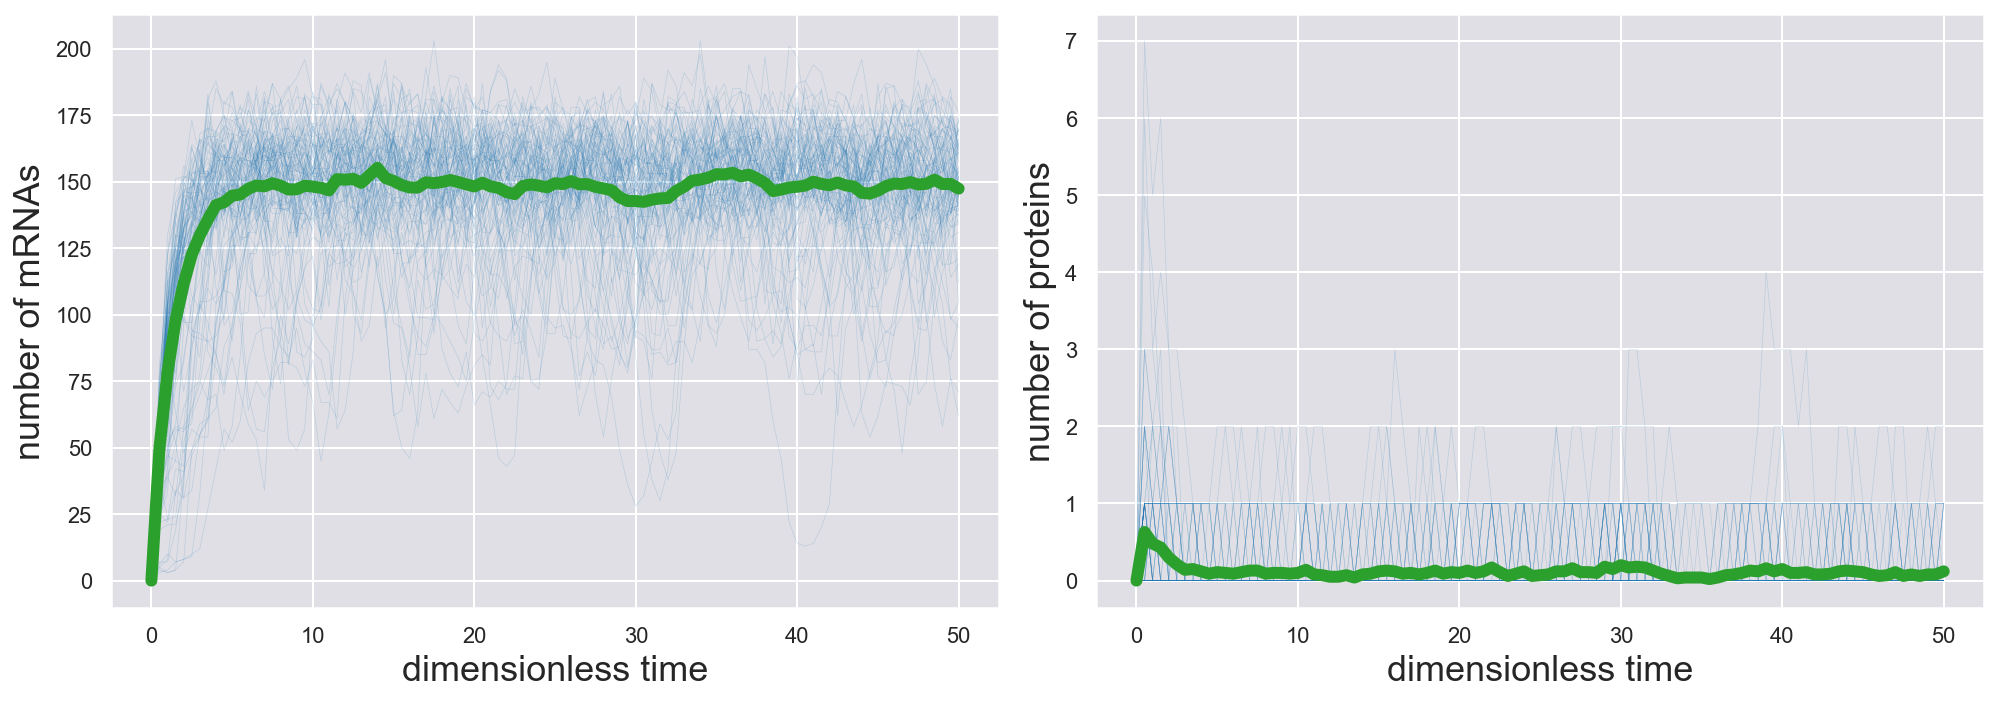

In [25]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

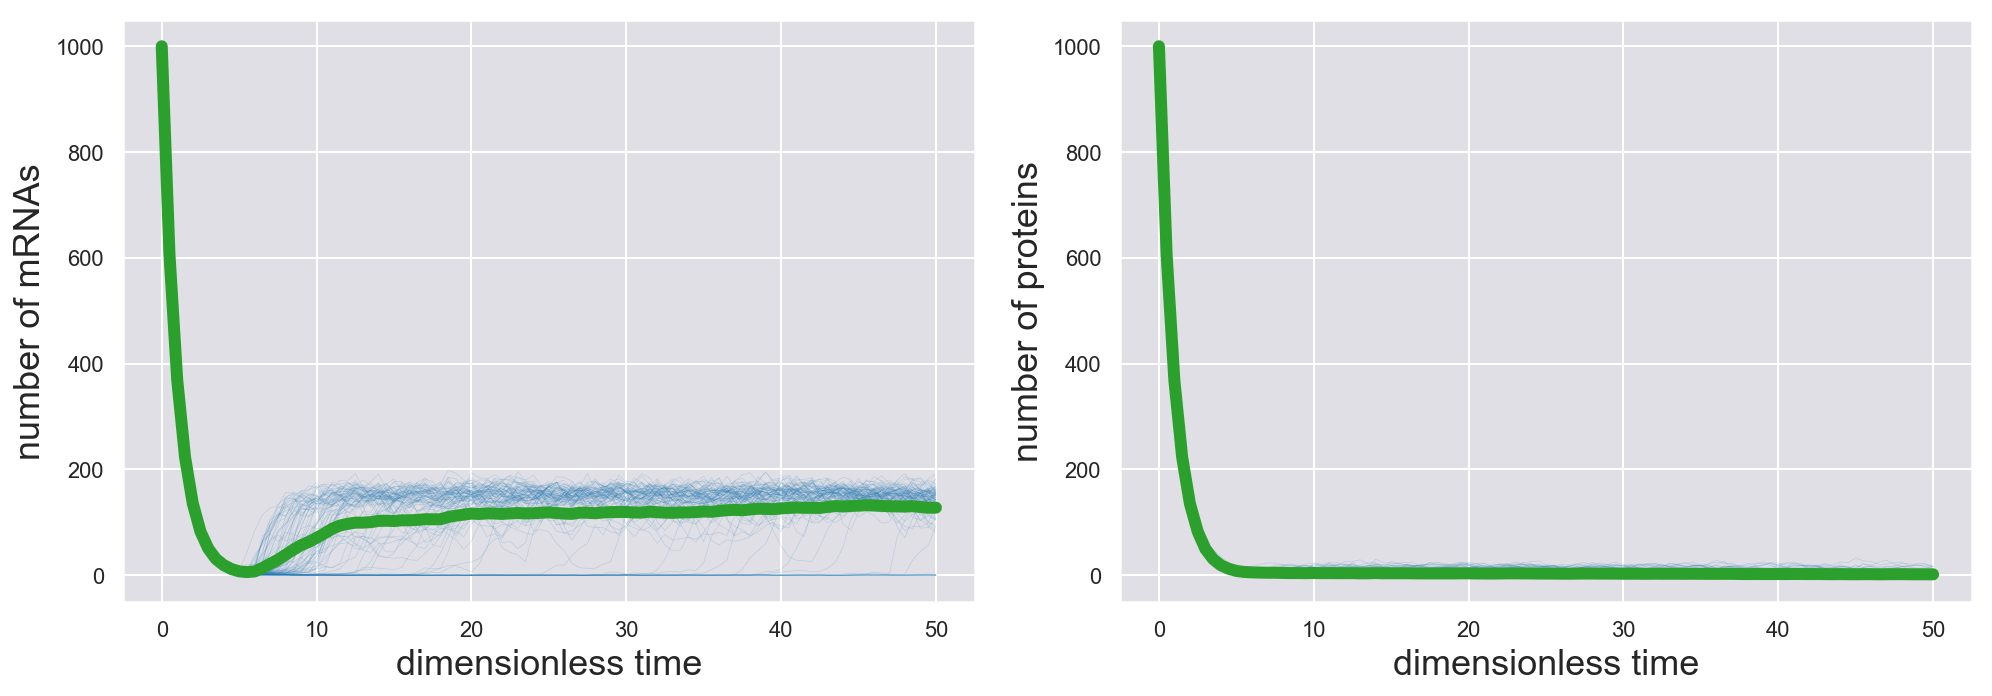

In [8]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[2])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  1.,  2.,  0.,  3.,  1.,  0.,  1.,  0.,  0.,  2.,  2.,  0.,
         1.,  1.,  0.,  1.,  2.,  2.,  1.,  4.,  2.,  4.,  5.,  5.,  0.,
         4.,  3.,  7.,  6.,  2.,  5.,  3.,  4.,  2.,  0.,  2.,  1.,  1.,
         1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([  0.  ,   1.91,   3.82,   5.73,   7.64,   9.55,  11.46,  13.37,
         15.28,  17.19,  19.1 ,  21.01,  22.92,  24.83,  26.74,  28.65,
         30.56,  32.47,  34.38,  36.29,  38.2 ,  40.11,  42.02,  43.93,
         45.84,  47.75,  49.66,  51.57,  53.48,  55.39,  57.3 ,  59.21,
         61.12,  63.03,  64.94,  66.85,  68.76,  70.67,  72.58,  74.49,
         76.4 ,  78.31,  80.22,  82.13,  84.04,  85.95,  87.86,  89.77,
  

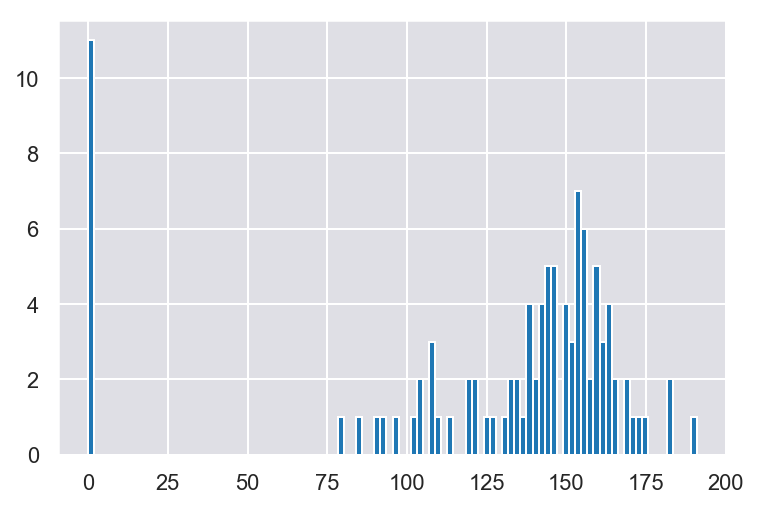

In [10]:
p_hist = np.hstack(pops[:,-1,0])
plt.hist(p_hist, bins=100)

In [66]:
pops[:,-1,0]

array([500., 478., 513., 503., 536., 521., 507., 478., 512., 467., 488.,
       510., 483., 514., 548., 489., 495., 489., 491., 459., 494., 500.,
       473., 480., 521., 501., 485., 487., 529., 446., 502., 503., 472.,
       542., 481., 480., 533., 497., 495., 471., 481., 487., 515., 515.,
       525., 541., 517., 488., 544., 522., 499., 533., 469., 473., 556.,
       497., 497., 455., 477., 510., 489., 487., 487., 467., 517., 500.,
       493., 475., 493., 464., 515., 496., 493., 505., 507., 499., 509.,
       535., 537., 479., 496., 488., 508., 474., 523., 501., 514., 462.,
       544., 517., 526., 487., 513., 492., 469., 462., 458., 505., 448.,
       505.])